In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import os
import random
import scienceplots
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science'])

## format setting

In [49]:
with open("bloodConc.json", 'r') as f:
    bloodConc = json.load(f)
    bloodConc = bloodConc['bloodConc']
with open("SO2.json", 'r') as f:
    SO2 = json.load(f)
    test_SO2 = SO2['test_SO2']
    train_SO2 = SO2['train_SO2']
with open("mua_spectrum.json", 'r') as f:
    data = json.load(f)

SO2_used = {'SO2':[0.35,0.4,0.425,0.5,0.55,0.575,0.6,0.65,0.675,0.7,0.725,0.75,0.775,0.8,0.825,0.85,0.875,0.9,0.925,0.95]}
tissue_SO2_used = {'train_SO2':[0.35,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95],
            'test_SO2':[0.35,0.4,0.425,0.5,0.55,0.575,0.6,0.65,0.675,0.7,0.725,0.75,0.775,0.8,0.825,0.85,0.875,0.9,0.925,0.95]
            }
SO2_used = SO2_used['SO2']
with open(os.path.join("tissue_SO2.json"), 'w') as f:
    json.dump(tissue_SO2_used, f , indent=4)
    
used_skin_spec = pd.DataFrame(data['skin']).to_numpy() # Nx : condition Ny : wavelengths
used_fat_spec = pd.DataFrame(data['fat']).to_numpy() # Nx : condition Ny : wavelengths
used_muscle_spec = pd.DataFrame(data['muscle']).to_numpy() # Nx : condition Ny : wavelengths
used_cca_spec = pd.DataFrame(data['cca']).to_numpy() # Nx : condition Ny : wavelengths

# get ijv spec
count = 0
for blc in bloodConc:
    for using_SO2 in test_SO2:
        if count == 0:
            used_ijv_spec = pd.DataFrame(data[f'ijv_bloodConc_{blc}_bloodSO2_{using_SO2}']).to_numpy().reshape(1,-1)
        else:
            temp = pd.DataFrame(data[f'ijv_bloodConc_{blc}_bloodSO2_{using_SO2}']).to_numpy().reshape(1,-1)
            used_ijv_spec = np.concatenate((used_ijv_spec, temp))
        count += 1


compare_mua_spec = {'skin': used_skin_spec,
                    'fat': used_fat_spec,
                    'muscle': used_muscle_spec,
                    'ijv' : used_ijv_spec,
                    'cca': used_cca_spec}

with open("wavelength.json", "r") as f:
    used_wavelength = json.load(f)
used_wavelength = used_wavelength['wavelength']

## load absorbing_chromophores

In [4]:
data = pd.read_csv('absorbing_chromophores.csv')

# get correspond wavelength
wavelength = data['wl'].to_numpy() # convert 1/cm --> 1/mm
find_same_wl_idx = []
for i in range(len(used_wavelength)):
    find_same_wl_idx += [np.where(wavelength == used_wavelength[i])[0][0]]

# adjust wavelength 
mel_mua_spec = data['melanan(cm)'].to_numpy()[find_same_wl_idx]*0.1 # convert 1/cm --> 1/mm
epi_mua_spec = data['epithelial cells(cm)'].to_numpy()[find_same_wl_idx]*0.1 # convert 1/cm --> 1/mm
hbo2_mua_spec = data['hbo2(cm)'].to_numpy()[find_same_wl_idx]*0.1 # convert 1/cm --> 1/mm
hb_mua_spec = data['hb(cm)'].to_numpy()[find_same_wl_idx]*0.1 # convert 1/cm --> 1/mm
col_mua_spec = data['collagen(cm)'].to_numpy()[find_same_wl_idx]*0.1 # convert 1/cm --> 1/mm
water_mua_spec = data['water(cm)'].to_numpy()[find_same_wl_idx]*0.1 # convert 1/cm --> 1/mm
lipid_mua_spec = data['lipid(cm)'].to_numpy()[find_same_wl_idx]*0.1 # convert 1/cm --> 1/mm


# plot absorbing_chromophores

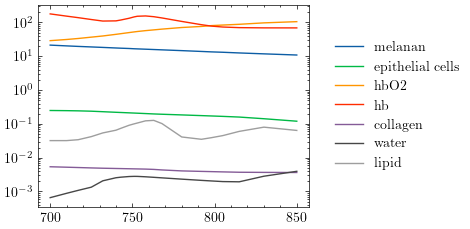

In [5]:
plt.plot(used_wavelength, mel_mua_spec, label='melanan')
plt.plot(used_wavelength, epi_mua_spec, label='epithelial cells')
plt.plot(used_wavelength, hbo2_mua_spec, label='hbO2')
plt.plot(used_wavelength, hb_mua_spec, label='hb')
plt.plot(used_wavelength, col_mua_spec, label='collagen')
plt.plot(used_wavelength, water_mua_spec, label='water')
plt.plot(used_wavelength, lipid_mua_spec, label='lipid')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.yscale('log')
plt.show()

## get mua spec function

In [15]:
def get_mua_spec(gen_num, tissue, compare_spec, f_blood_bound, SO2_bound, f_fat_bound, f_water_bound, f_mel_bound, f_col_bound):
    used_frac = pd.DataFrame({'f_blood': [],
                'f_fat': [],
                'f_water': [],
                'f_mel': [],
                'f_col': [],
                'SO2': [],
                'total_ratio': [],
                'count': []
                })
    
    mua_spectra = {}
    for wl in used_wavelength:
        mua_spectra[f'{wl}nm'] = []
    for i in range(gen_num):
        total_ratio = 0
        count = 0
        mua = np.array([-1,-1])
        if i == 0 :
            if (tissue == 'ijv') or (tissue == 'cca'):
                f_blood = f_blood_bound[0]
                SO2 = SO2_bound[0]
                f_fat = f_fat_bound[0]
                f_water = f_water_bound[0]
                f_mel = f_mel_bound[0]
                f_col = f_col_bound[0]
                total_ratio = f_blood + f_fat + f_water + f_mel + f_col
                mua = f_water*water_mua_spec + f_mel*mel_mua_spec + f_fat*lipid_mua_spec + SO2*f_blood*150*2.303/64500*hbo2_mua_spec + (1-SO2)*f_blood*150*2.303/64500*hb_mua_spec + f_col*col_mua_spec
                count += 1
            else:
                while not ((mua.max()<compare_spec.max()) & (mua.min()>compare_spec.min())): # find the mua is under the literature region
                    f_blood = f_blood_bound[0]
                    SO2 = SO2_bound[0]
                    f_fat = f_fat_bound[0]
                    f_water = f_water_bound[0]
                    f_mel = f_mel_bound[0]
                    f_col = f_col_bound[0]
                    total_ratio = f_blood + f_fat + f_water + f_mel + f_col
                    mua = f_water*water_mua_spec + f_mel*mel_mua_spec + f_fat*lipid_mua_spec + SO2*f_blood*150*2.303/64500*hbo2_mua_spec + (1-SO2)*f_blood*150*2.303/64500*hb_mua_spec + f_col*col_mua_spec
                    count += 1
            mua = f_water*water_mua_spec + f_mel*mel_mua_spec + f_fat*lipid_mua_spec + SO2*f_blood*150*2.303/64500*hbo2_mua_spec + (1-SO2)*f_blood*150*2.303/64500*hb_mua_spec + f_col*col_mua_spec
            add_frac = pd.DataFrame({'f_blood': [f_blood],
                        'f_fat': [f_fat],
                        'f_water': [f_water],
                        'f_mel': [f_mel],
                        'f_col': [f_col],
                        'SO2': [SO2],
                        'total_ratio': [total_ratio],
                        'count': [count]})
            used_frac = pd.concat((used_frac, add_frac), ignore_index=True)


        elif  i == (gen_num-1):
            if (tissue == 'ijv') or (tissue == 'cca'):
                f_blood = f_blood_bound[1]
                SO2 = SO2_bound[1]
                f_fat = f_fat_bound[1]
                f_water = f_water_bound[1]
                f_mel = f_mel_bound[1]
                f_col = f_col_bound[1]
                total_ratio = f_blood + f_fat + f_water + f_mel + f_col
                mua = f_water*water_mua_spec + f_mel*mel_mua_spec + f_fat*lipid_mua_spec + SO2*f_blood*150*2.303/64500*hbo2_mua_spec + (1-SO2)*f_blood*150*2.303/64500*hb_mua_spec + f_col*col_mua_spec
                count += 1
            else:
                while not ((mua.max()<compare_spec.max()) & (mua.min()>compare_spec.min())): # find the mua is under the literature region
                    f_blood = f_blood_bound[1]
                    SO2 = SO2_bound[1]
                    f_fat = f_fat_bound[1]
                    f_water = f_water_bound[1]
                    f_mel = f_mel_bound[1]
                    f_col = f_col_bound[1]
                    total_ratio = f_blood + f_fat + f_water + f_mel + f_col
                    mua = f_water*water_mua_spec + f_mel*mel_mua_spec + f_fat*lipid_mua_spec + SO2*f_blood*150*2.303/64500*hbo2_mua_spec + (1-SO2)*f_blood*150*2.303/64500*hb_mua_spec + f_col*col_mua_spec
                    count += 1
            mua = f_water*water_mua_spec + f_mel*mel_mua_spec + f_fat*lipid_mua_spec + SO2*f_blood*150*2.303/64500*hbo2_mua_spec + (1-SO2)*f_blood*150*2.303/64500*hb_mua_spec + f_col*col_mua_spec
            add_frac = pd.DataFrame({'f_blood': [f_blood],
                        'f_fat': [f_fat],
                        'f_water': [f_water],
                        'f_mel': [f_mel],
                        'f_col': [f_col],
                        'SO2': [SO2],
                        'total_ratio': [total_ratio],
                        'count': [count]})
            used_frac = pd.concat((used_frac, add_frac), ignore_index=True)


        else:
            if (tissue == 'ijv') or (tissue == 'cca'):
                f_blood = random.uniform(f_blood_bound[0], f_blood_bound[1])
                SO2 = random.uniform(SO2_bound[0], SO2_bound[1])
                f_fat = random.uniform(f_fat_bound[0], f_fat_bound[1])
                f_water = random.uniform(f_water_bound[0], f_water_bound[1])
                f_mel = random.uniform(f_mel_bound[0], f_mel_bound[1])
                f_col = random.uniform(f_col_bound[0], f_col_bound[1])
                total_ratio = f_blood + f_fat + f_water + f_mel + f_col
                mua = f_water*water_mua_spec + f_mel*mel_mua_spec + f_fat*lipid_mua_spec + SO2*f_blood*150*2.303/64500*hbo2_mua_spec + (1-SO2)*f_blood*150*2.303/64500*hb_mua_spec + f_col*col_mua_spec
                count += 1
            else:
                while not ((mua.max()<compare_spec.max()) & (mua.min()>compare_spec.min())): # find the mua is under the literature region
                    f_blood = random.uniform(f_blood_bound[0], f_blood_bound[1])
                    SO2 = random.uniform(SO2_bound[0], SO2_bound[1])
                    f_fat = random.uniform(f_fat_bound[0], f_fat_bound[1])
                    f_water = random.uniform(f_water_bound[0], f_water_bound[1])
                    f_mel = random.uniform(f_mel_bound[0], f_mel_bound[1])
                    f_col = random.uniform(f_col_bound[0], f_col_bound[1])
                    total_ratio = f_blood + f_fat + f_water + f_mel + f_col
                    mua = f_water*water_mua_spec + f_mel*mel_mua_spec + f_fat*lipid_mua_spec + SO2*f_blood*150*2.303/64500*hbo2_mua_spec + (1-SO2)*f_blood*150*2.303/64500*hb_mua_spec + f_col*col_mua_spec
                    count += 1
            mua = f_water*water_mua_spec + f_mel*mel_mua_spec + f_fat*lipid_mua_spec + SO2*f_blood*150*2.303/64500*hbo2_mua_spec + (1-SO2)*f_blood*150*2.303/64500*hb_mua_spec + f_col*col_mua_spec
            add_frac = pd.DataFrame({'f_blood': [f_blood],
                        'f_fat': [f_fat],
                        'f_water': [f_water],
                        'f_mel': [f_mel],
                        'f_col': [f_col],
                        'SO2': [SO2],
                        'total_ratio': [total_ratio],
                        'count': [count]})
            used_frac = pd.concat((used_frac, add_frac), ignore_index=True)
        for wl_idx, wl in enumerate(used_wavelength):
            mua_spectra[f'{wl}nm'] += [mua[wl_idx]]
    
    mua_spectra = pd.DataFrame(mua_spectra)
    return used_frac, mua_spectra

## get tissue SO2 change mua spec function (skin、fat)

In [46]:
def get_tissueSO2_change_mua_spec(SO2_used, tissue, compare_spec, f_blood_bound, f_fat_bound, f_water_bound, f_mel_bound, f_col_bound):
    used_frac = pd.DataFrame({'SO2': [],
                'f_blood': [],
                'f_fat': [],
                'f_water': [],
                'f_mel': [],
                'f_col': [],
                'SO2': [],
                'total_ratio': [],
                'count': []
                })
    
    # mua_spectra = {}
    # for wl in used_wavelength:
    #     mua_spectra[f'{wl}nm'] = []
    mua_save = np.empty((len(SO2_used), len(used_wavelength)+1)) # record SO2 + wavelength
    for idx, SO2 in enumerate(SO2_used):
        total_ratio = 0
        count = 0
        mua = np.array([-1,-1])
        if idx == 0:
            while not ((mua.max()<compare_spec.max()) & (mua.min()>compare_spec.min())): # find the mua is under the literature region
                f_blood = f_blood_bound[0]
                f_fat = f_fat_bound[0]
                f_water = f_water_bound[0]
                f_mel = f_mel_bound[0]
                f_col = f_col_bound[0]
                total_ratio = f_blood + f_fat + f_water + f_mel + f_col
                mua = f_water*water_mua_spec + f_mel*mel_mua_spec + f_fat*lipid_mua_spec + SO2*f_blood*150*2.303/64500*hbo2_mua_spec + (1-SO2)*f_blood*150*2.303/64500*hb_mua_spec + f_col*col_mua_spec
                count += 1
            mua = f_water*water_mua_spec + f_mel*mel_mua_spec + f_fat*lipid_mua_spec + SO2*f_blood*150*2.303/64500*hbo2_mua_spec + (1-SO2)*f_blood*150*2.303/64500*hb_mua_spec + f_col*col_mua_spec
            add_frac = pd.DataFrame({'SO2': [SO2],
                        'f_blood': [f_blood],
                        'f_fat': [f_fat],
                        'f_water': [f_water],
                        'f_mel': [f_mel],
                        'f_col': [f_col],
                        'SO2': [SO2],
                        'total_ratio': [total_ratio],
                        'count': [count]})
            used_frac = pd.concat((used_frac, add_frac), ignore_index=True)

            mua_save[idx] = np.array([SO2]+list(mua))
        elif idx == (len(SO2_used)-1):
            while not ((mua.max()<compare_spec.max()) & (mua.min()>compare_spec.min())): # find the mua is under the literature region
                    f_blood = f_blood_bound[1]
                    f_fat = f_fat_bound[1]
                    f_water = f_water_bound[1]
                    f_mel = f_mel_bound[1]
                    f_col = f_col_bound[1]
                    total_ratio = f_blood + f_fat + f_water + f_mel + f_col
                    mua = f_water*water_mua_spec + f_mel*mel_mua_spec + f_fat*lipid_mua_spec + SO2*f_blood*150*2.303/64500*hbo2_mua_spec + (1-SO2)*f_blood*150*2.303/64500*hb_mua_spec + f_col*col_mua_spec
                    count += 1
            mua = f_water*water_mua_spec + f_mel*mel_mua_spec + f_fat*lipid_mua_spec + SO2*f_blood*150*2.303/64500*hbo2_mua_spec + (1-SO2)*f_blood*150*2.303/64500*hb_mua_spec + f_col*col_mua_spec
            add_frac = pd.DataFrame({'SO2': [SO2],
                        'f_blood': [f_blood],
                        'f_fat': [f_fat],
                        'f_water': [f_water],
                        'f_mel': [f_mel],
                        'f_col': [f_col],
                        'SO2': [SO2],
                        'total_ratio': [total_ratio],
                        'count': [count]})
            used_frac = pd.concat((used_frac, add_frac), ignore_index=True)

            mua_save[idx] = np.array([SO2]+list(mua))
        else:
            while not ((mua.max()<compare_spec.max()) & (mua.min()>compare_spec.min())): # find the mua is under the literature region
                f_blood = random.uniform(f_blood_bound[0], f_blood_bound[1])
                f_fat = random.uniform(f_fat_bound[0], f_fat_bound[1])
                f_water = random.uniform(f_water_bound[0], f_water_bound[1])
                f_mel = random.uniform(f_mel_bound[0], f_mel_bound[1])
                f_col = random.uniform(f_col_bound[0], f_col_bound[1])
                total_ratio = f_blood + f_fat + f_water + f_mel + f_col
                mua = f_water*water_mua_spec + f_mel*mel_mua_spec + f_fat*lipid_mua_spec + SO2*f_blood*150*2.303/64500*hbo2_mua_spec + (1-SO2)*f_blood*150*2.303/64500*hb_mua_spec + f_col*col_mua_spec
                count += 1
            mua = f_water*water_mua_spec + f_mel*mel_mua_spec + f_fat*lipid_mua_spec + SO2*f_blood*150*2.303/64500*hbo2_mua_spec + (1-SO2)*f_blood*150*2.303/64500*hb_mua_spec + f_col*col_mua_spec
            add_frac = pd.DataFrame({'SO2': [SO2],
                        'f_blood': [f_blood],
                        'f_fat': [f_fat],
                        'f_water': [f_water],
                        'f_mel': [f_mel],
                        'f_col': [f_col],
                        'SO2': [SO2],
                        'total_ratio': [total_ratio],
                        'count': [count]})
            used_frac = pd.concat((used_frac, add_frac), ignore_index=True)

            mua_save[idx] = np.array([SO2]+list(mua))
        
    columns = ['SO2'] + [f'{wl}_nm' for wl in used_wavelength]
        

        # for wl_idx, wl in enumerate(used_wavelength):
        #     mua_spectra[f'{wl}nm'] += [mua[wl_idx]]
    mua_save = pd.DataFrame(mua_save, columns=columns)
    # mua_spectra = pd.DataFrame(mua_spectra)
    return used_frac, mua_save

## setting mua bound for each tissue layer

In [8]:
absorbing_chromophores_bound = {}
absorbing_chromophores_bound['skin'] = {}
absorbing_chromophores_bound['skin']['f_blood_bound'] = [0.001, 0.005] # [min, max]
# absorbing_chromophores_bound['skin']['SO2_bound'] = [0.65, 0.75] # [min, max] 
absorbing_chromophores_bound['skin']['f_fat_bound'] = [0.000, 0.000] # [min, max]
absorbing_chromophores_bound['skin']['f_water_bound'] = [0.66, 0.78] # [ min, max]
absorbing_chromophores_bound['skin']['f_mel_bound'] = [0.003, 0.006] # [min, max]
absorbing_chromophores_bound['skin']['f_col_bound'] = [0.1, 0.2] # [min, max]

absorbing_chromophores_bound['fat'] = {}
absorbing_chromophores_bound['fat']['f_blood_bound'] = [0.0001, 0.0005] # [min, max]
# absorbing_chromophores_bound['fat']['SO2_bound'] = [0.65, 0.75] # [min, max]
absorbing_chromophores_bound['fat']['f_fat_bound'] = [0.7, 0.85] # [min, max]
absorbing_chromophores_bound['fat']['f_water_bound'] = [0.1, 0.2] # [min, max]
absorbing_chromophores_bound['fat']['f_mel_bound'] = [0, 0] # [min, max]
absorbing_chromophores_bound['fat']['f_col_bound'] = [0, 0] # [min, max]

absorbing_chromophores_bound['muscle'] = {}
absorbing_chromophores_bound['muscle']['f_blood_bound'] = [0.050, 0.01] # [min, max]
absorbing_chromophores_bound['muscle']['SO2_bound'] = [0.65, 0.75] # [min, max]
absorbing_chromophores_bound['muscle']['f_fat_bound'] = [0, 0] # [min, max]
absorbing_chromophores_bound['muscle']['f_water_bound'] = [0.7, 1] # [min, max]
absorbing_chromophores_bound['muscle']['f_mel_bound'] = [0, 0] # [min, max]
absorbing_chromophores_bound['muscle']['f_col_bound'] = [0.1, 0.4] # [min, max]

absorbing_chromophores_bound['ijv'] = {}
absorbing_chromophores_bound['ijv']['f_blood_bound'] = [1, 1] # [min, max]
absorbing_chromophores_bound['ijv']['SO2_bound'] = [0.4, 0.9] # [min, max]
absorbing_chromophores_bound['ijv']['f_fat_bound'] = [0, 0] # [min, max]
absorbing_chromophores_bound['ijv']['f_water_bound'] = [0, 0] # [min, max]
absorbing_chromophores_bound['ijv']['f_mel_bound'] = [0, 0] # [min, max]
absorbing_chromophores_bound['ijv']['f_col_bound'] = [0, 0] # [min, max]

absorbing_chromophores_bound['cca'] = {}
absorbing_chromophores_bound['cca']['f_blood_bound'] = [1, 1] # [min, max]
absorbing_chromophores_bound['cca']['SO2_bound'] = [0.8, 1] # [min, max]
absorbing_chromophores_bound['cca']['f_fat_bound'] = [0, 0] # [min, max]
absorbing_chromophores_bound['cca']['f_water_bound'] = [0, 0] # [min, max]
absorbing_chromophores_bound['cca']['f_mel_bound'] = [0, 0] # [min, max]
absorbing_chromophores_bound['cca']['f_col_bound'] = [0, 0] # [min, max]



In [16]:
# mua = [blood, SO2, fat, water, melanin, collagen]
tissue_set = ['muscle', 'ijv', 'cca']

os.makedirs('used_fraction', exist_ok=True)
os.makedirs('mua_chromophore', exist_ok=True)

for tissue in tissue_set:
    f_blood_bound = absorbing_chromophores_bound[tissue]['f_blood_bound']
    SO2_bound = absorbing_chromophores_bound[tissue]['SO2_bound']
    f_fat_bound = absorbing_chromophores_bound[tissue]['f_fat_bound']
    f_water_bound = absorbing_chromophores_bound[tissue]['f_water_bound']
    f_mel_bound = absorbing_chromophores_bound[tissue]['f_mel_bound']
    f_col_bound = absorbing_chromophores_bound[tissue]['f_col_bound']
    if tissue == 'ijv':
      pass
    else:
      compare_spec = compare_mua_spec[tissue] 
    
    used_frac, mua_spectra = get_mua_spec(gen_num = 20, 
                                          tissue = tissue,
                                          compare_spec = compare_spec,
                                          f_blood_bound = f_blood_bound, 
                                          SO2_bound = SO2_bound, 
                                          f_fat_bound = f_fat_bound,
                                          f_water_bound = f_water_bound,
                                          f_mel_bound = f_mel_bound,
                                          f_col_bound = f_col_bound)
    used_frac.to_csv(os.path.join("used_fraction", f"{tissue}_used_frac.csv"), index=False)
    mua_spectra.to_csv(os.path.join("mua_chromophore", f"{tissue}_mua_spectrum.csv"), index=False)
    



In [50]:

tissue_change_set = ['skin','fat']

for tissue in tissue_change_set:
    os.makedirs(f"{tissue}", exist_ok=True)
    f_blood_bound = absorbing_chromophores_bound[tissue]['f_blood_bound']
    f_fat_bound = absorbing_chromophores_bound[tissue]['f_fat_bound']
    f_water_bound = absorbing_chromophores_bound[tissue]['f_water_bound']
    f_mel_bound = absorbing_chromophores_bound[tissue]['f_mel_bound']
    f_col_bound = absorbing_chromophores_bound[tissue]['f_col_bound']
    if tissue == 'ijv':
      pass
    else:
      compare_spec = compare_mua_spec[tissue] 
    
    used_frac, mua_save = get_tissueSO2_change_mua_spec(SO2_used, 
                                          tissue = tissue,
                                          compare_spec = compare_spec,
                                          f_blood_bound = f_blood_bound,  
                                          f_fat_bound = f_fat_bound,
                                          f_water_bound = f_water_bound,
                                          f_mel_bound = f_mel_bound,
                                          f_col_bound = f_col_bound)
    used_frac.to_csv(os.path.join("used_fraction", f"{tissue}_used_frac.csv"), index=False)
    # mua_spectra.to_csv(os.path.join(f"{tissue}", f"{tissue}_mua_spectrum.csv"), index=False)
    mua_save.to_csv(os.path.join(f"{tissue}", f"{tissue}_mua_bloodConc_150.csv"), index=False)

    mua_spec = {}
    spec = pd.read_csv(os.path.join(f"{tissue}", f"{tissue}_mua_bloodConc_150.csv"))
    spec = spec.to_numpy()
    for s_idx, SO2 in enumerate(SO2_used):
        mua_spec[f'{tissue}_bloodSO2_{SO2}'] = list(spec[s_idx][1:]) # first element(0-index) represent SO2

    with open(os.path.join(f"{tissue}", f'{tissue}_mua_spectrum.json'), 'w') as f:
      json.dump(mua_spec, f, indent=4)

C:\Users\Ya Hua\AppData\Local\Temp\ipykernel_7736\234028529.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


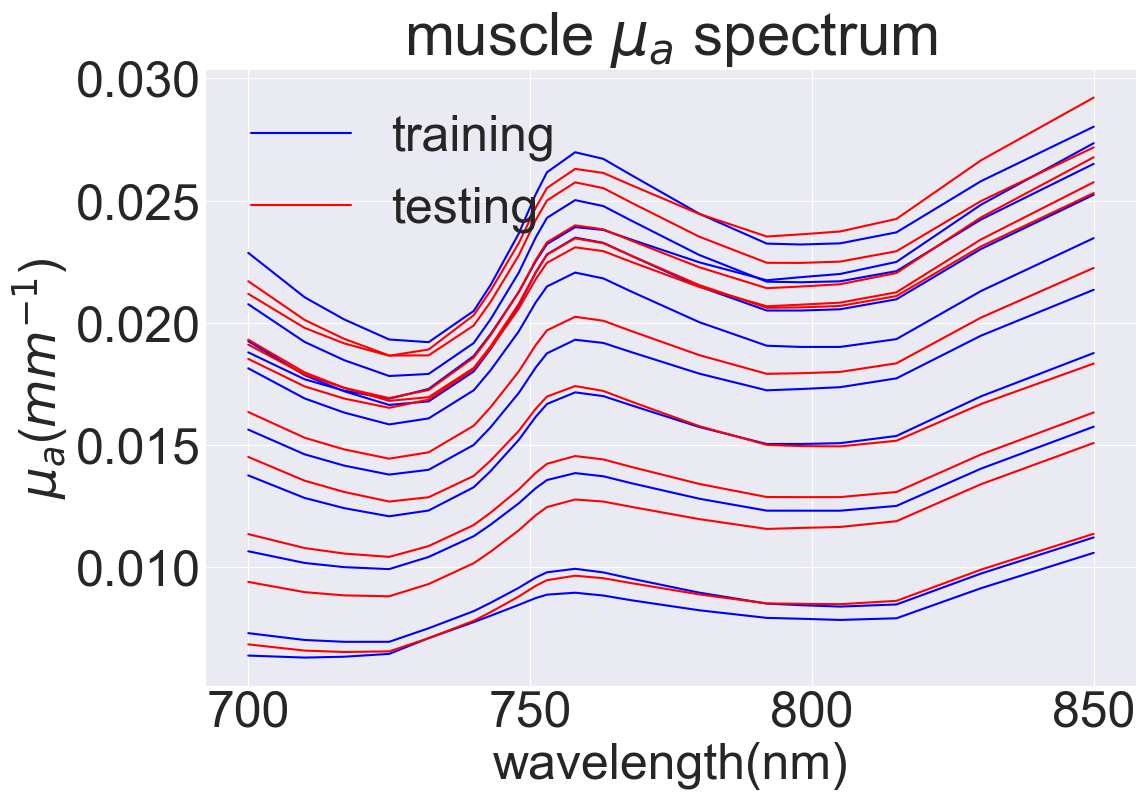

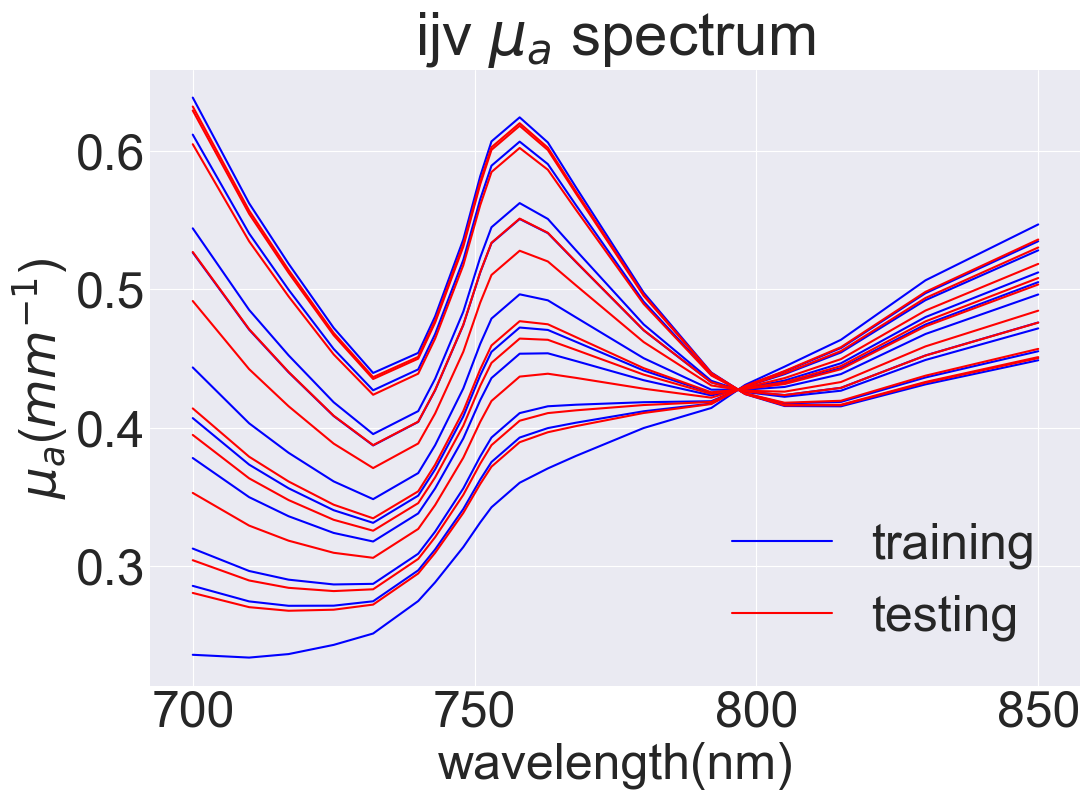

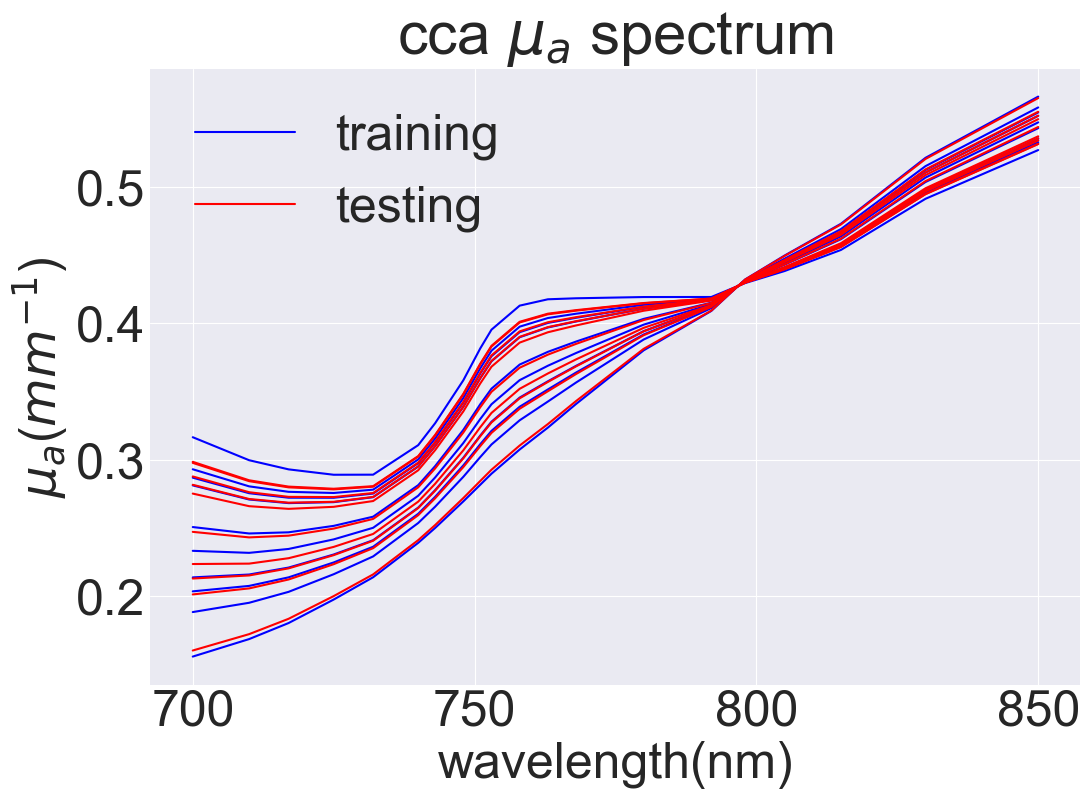

In [27]:
os.makedirs('pic', exist_ok=True)
tissue_set = ['muscle', 'ijv', 'cca']
# train_idx = [i for i in range(0,20,2)]
# test_idx = [i for i in range(1,20,2)]
train_idx = [i for i in range(0,18,2)]+[19]
test_idx = [i for i in range(1,19,2)]+[18]
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("seaborn-darkgrid")
plt.rcParams.update({'font.size': 36})
for tissue in tissue_set:
    used_spec = pd.read_csv(os.path.join("mua_chromophore", f"{tissue}_mua_spectrum.csv")).to_numpy()
    sort_idx = used_spec[:,0].argsort()
    used_spec = used_spec[sort_idx]
    plt.figure(figsize=(12,8))
    plt.title(f'{tissue} $\mu_a$ spectrum')
    for count, i in enumerate(train_idx):
        if count == 0:
            plt.plot(used_wavelength, used_spec[i], 'b', label='training')
        else:
            plt.plot(used_wavelength, used_spec[i], 'b')
    for count, i in enumerate(test_idx):
        if count == 0:
            plt.plot(used_wavelength, used_spec[i], 'r', label='testing')
        else:
            plt.plot(used_wavelength, used_spec[i], 'r')        
            
    # used_spec = compare_mua_spec[tissue]
    # for i in range(used_spec.shape[0]):
    #     if tissue == 'ijv':
    #         if i == 0:
    #             plt.plot(used_wavelength, used_spec[i], 'k', alpha=0.2, linewidth=0.5, label='origin')
    #         else:
    #             plt.plot(used_wavelength, used_spec[i], 'k', alpha=0.2, linewidth=0.5)
    #     else:
    #         if i == 0:
    #             plt.plot(used_wavelength, used_spec[i], 'k', label='origin')
    #         else:
    #             plt.plot(used_wavelength, used_spec[i], 'k')
    # plt.title(f'{tissue}')
    plt.xlabel('wavelength(nm)')
    plt.ylabel("$\mu_a$($mm^{-1}$)")
    # plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fancybox=True, shadow=True)
    plt.legend()
    plt.savefig(os.path.join("pic", f'{tissue}_mua_spectrum.png'), dpi=300, format='png', bbox_inches='tight')
    plt.show()

[0.35, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
[0.35, 0.4, 0.425, 0.5, 0.55, 0.575, 0.6, 0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]


C:\Users\Ya Hua\AppData\Local\Temp\ipykernel_7736\34955810.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


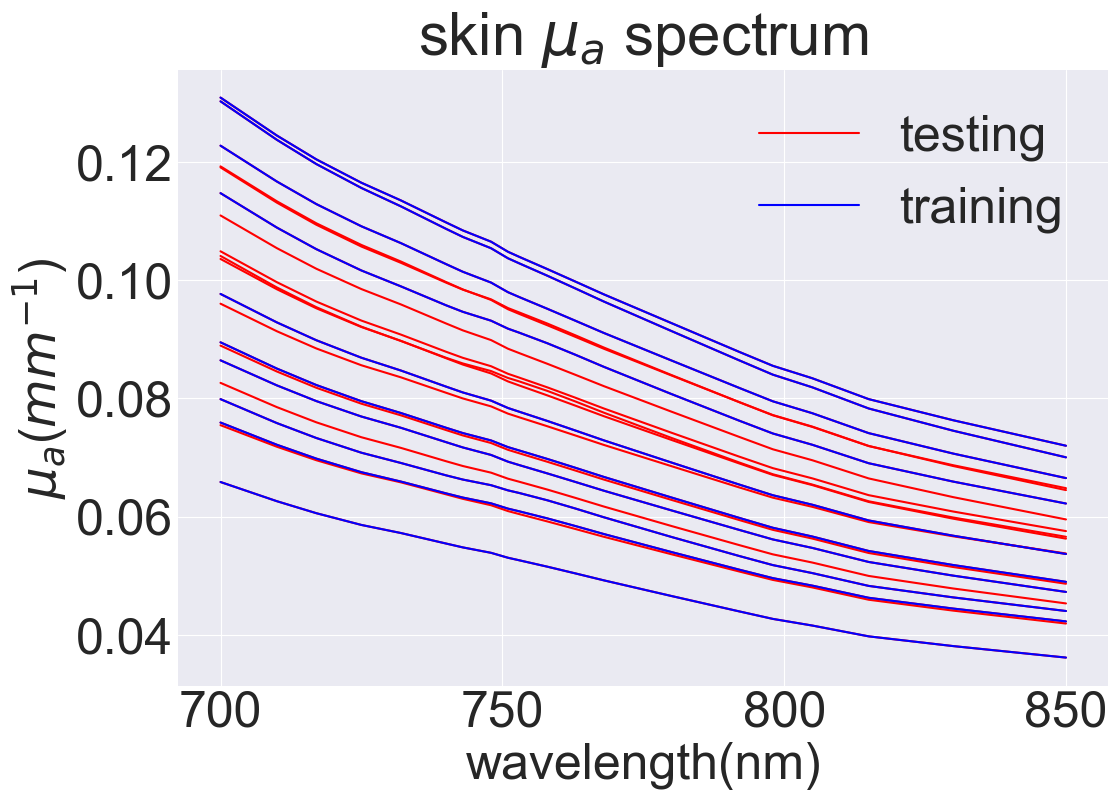

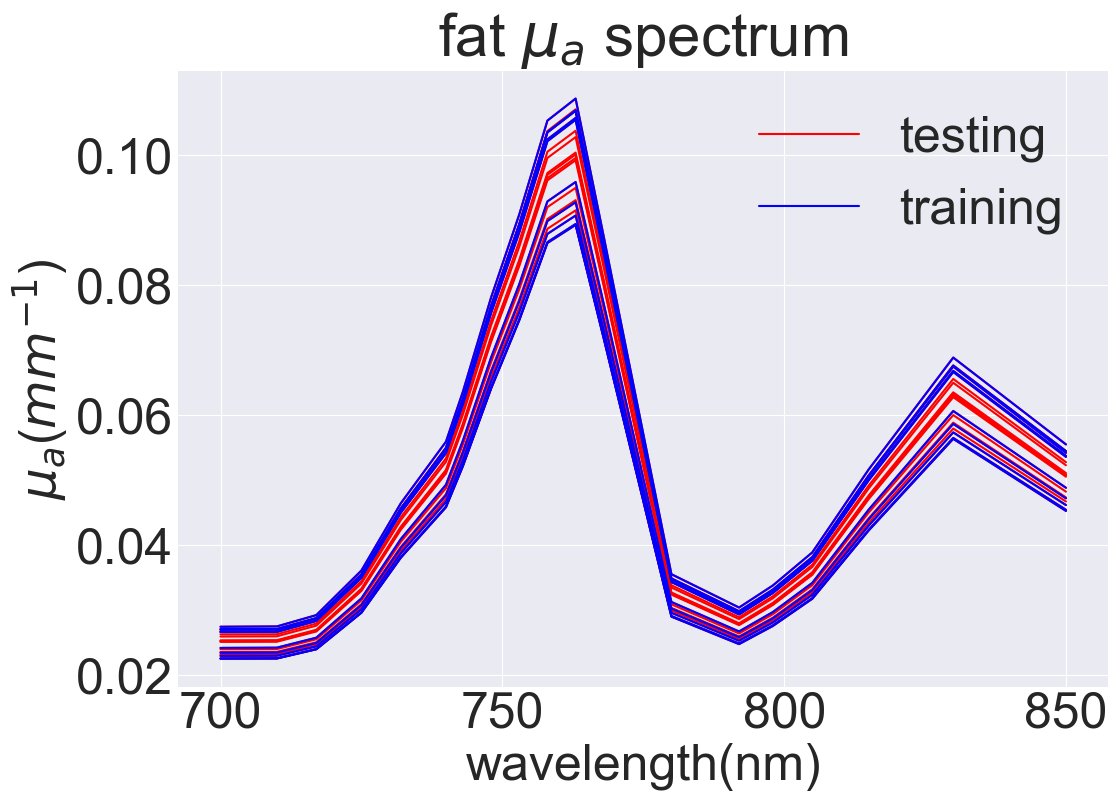

In [51]:
os.makedirs('pic', exist_ok=True)
tissue_set = ['skin','fat']
train_idx = tissue_SO2_used['train_SO2']
test_idx = tissue_SO2_used['test_SO2']
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("seaborn-darkgrid")
plt.rcParams.update({'font.size': 36})
for tissue in tissue_set:
    used_spec = pd.read_csv(os.path.join(f"{tissue}", f"{tissue}_mua_bloodConc_150.csv"))
    plt.figure(figsize=(12,8))
    plt.title(f'{tissue} $\mu_a$ spectrum')

    for i,SO2 in enumerate(test_idx):
        test_spec = used_spec[used_spec['SO2'] == SO2].to_numpy()
        test_spec = test_spec.reshape(-1)
        if i == 0:
            plt.plot(used_wavelength, test_spec[1:], 'r', label='testing')
        else:
            plt.plot(used_wavelength, test_spec[1:], 'r')
            
    for i,SO2 in enumerate(train_idx):
        train_spec = used_spec[used_spec['SO2'] == SO2].to_numpy()
        train_spec = train_spec.reshape(-1)
        if i == 0:
            plt.plot(used_wavelength, train_spec[1:], 'b', label='training')
        else:
            plt.plot(used_wavelength, train_spec[1:], 'b')
                


   

    plt.xlabel('wavelength(nm)')
    plt.ylabel("$\mu_a$($mm^{-1}$)")
    # plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fancybox=True, shadow=True)
    plt.legend()
    plt.savefig(os.path.join("pic", f'{tissue}_mua_spectrum.png'), dpi=300, format='png', bbox_inches='tight')
    plt.show()

### mua_gen --> for ijv     

In [14]:
with open("bloodConc.json", 'r') as f:
    bloodConc = json.load(f)
    bloodConc = bloodConc['bloodConc']
with open("SO2.json", 'r') as f:
    SO2 = json.load(f)
    test_SO2 = SO2['test_SO2']
    train_SO2 = SO2['train_SO2']
with open("mua_spectrum.json", 'r') as f:
    ijv_data = json.load(f)
with open("wavelength.json", "r") as f:
    used_wavelength = json.load(f)
used_wavelength = used_wavelength['wavelength']


### Plot ijv_ua

C:\Users\Ya Hua\AppData\Local\Temp\ipykernel_20156\1878068181.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


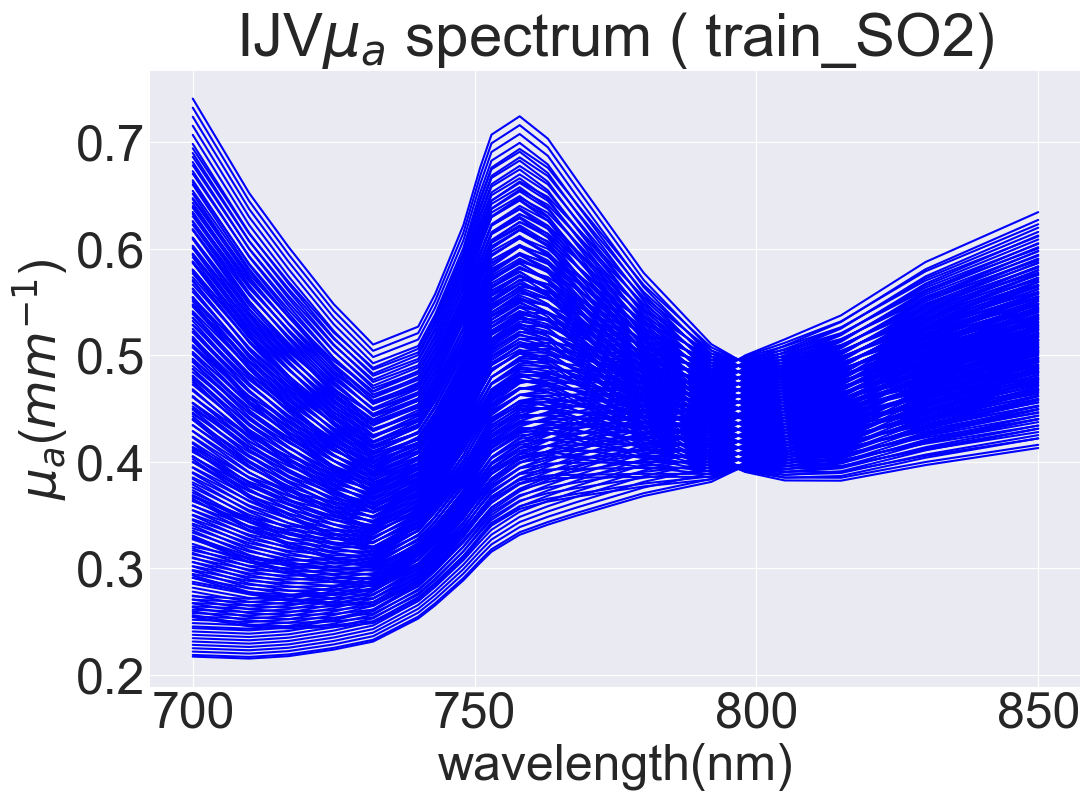

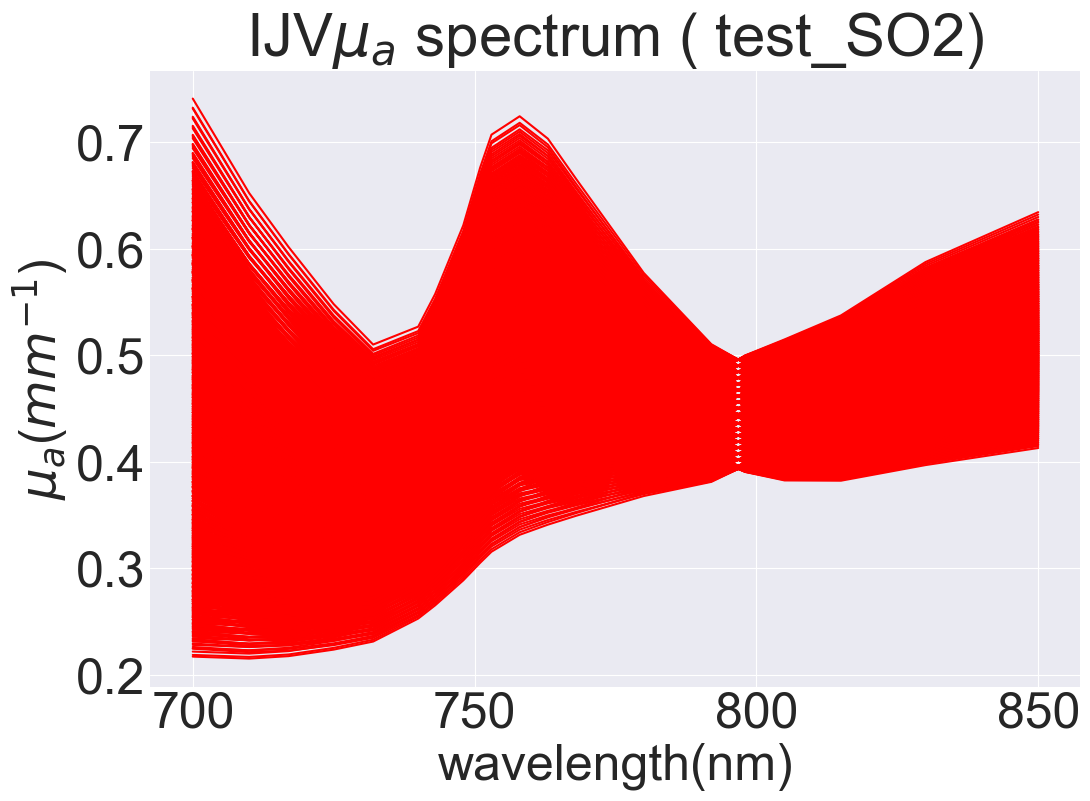

In [18]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("seaborn-darkgrid")
plt.rcParams.update({'font.size': 36})
count = 0

SO2_set = ['train_SO2', 'test_SO2']
for SO2_type in SO2_set:
    plt.figure(figsize=(12,8))
    plt.title(f'IJV$\mu_a$ spectrum ( {SO2_type})')
    for blc in bloodConc:
        if SO2_type == 'train_SO2':
            for i,using_SO2 in enumerate(train_SO2):
                if i == 0:
                    used_ijv_spec = pd.DataFrame(ijv_data[f'ijv_bloodConc_{blc}_bloodSO2_{using_SO2}']).to_numpy().reshape(1,-1)
                    plt.plot(used_wavelength, used_ijv_spec[i], 'b', label='training')
                else:
                    temp = pd.DataFrame(ijv_data[f'ijv_bloodConc_{blc}_bloodSO2_{using_SO2}']).to_numpy().reshape(1,-1)
                    used_ijv_spec = np.concatenate((used_ijv_spec, temp))
                    plt.plot(used_wavelength, used_ijv_spec[i], 'b')
        else:
            for i,using_SO2 in enumerate(test_SO2):
                if i == 0:
                    used_ijv_spec = pd.DataFrame(ijv_data[f'ijv_bloodConc_{blc}_bloodSO2_{using_SO2}']).to_numpy().reshape(1,-1)
                    plt.plot(used_wavelength, used_ijv_spec[i], 'r', label='training')
                else:
                    temp = pd.DataFrame(ijv_data[f'ijv_bloodConc_{blc}_bloodSO2_{using_SO2}']).to_numpy().reshape(1,-1)
                    used_ijv_spec = np.concatenate((used_ijv_spec, temp))
                    plt.plot(used_wavelength, used_ijv_spec[i], 'r')

    plt.xlabel('wavelength(nm)')
    plt.ylabel("$\mu_a$($mm^{-1}$)")
    # plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fancybox=True, shadow=True)
    if SO2_type == train_SO2:
        plt.savefig(os.path.join("pic", f'IJV_mua_spectrum_train_data.png'), dpi=300, format='png', bbox_inches='tight')
    else:
        plt.savefig(os.path.join("pic", f'IJV_mua_spectrum_test_data.png'), dpi=300, format='png', bbox_inches='tight')
    plt.show()
                